In [211]:
# !pip install plotly cufflinks pandas-gbq
# !pip install h5py~=2.10.0

In [212]:
# pip install "notebook>=5.3" "ipywidgets>=7.5"

In [213]:
import warnings
import plotly
import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
cf.go_offline()

# NYC Taxi Traffic EDA 1 - Time

## January: Total Trip Count

In [214]:
project_id='nyc-taxi-308416'

In [215]:
query = """
SELECT
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id=project_id)

In [216]:
df.tail(10)

,pickup_hour,cnt
734,2015-01-31 14:00:00,25059
735,2015-01-31 15:00:00,25886
736,2015-01-31 16:00:00,23822
737,2015-01-31 17:00:00,25794
738,2015-01-31 18:00:00,30804
739,2015-01-31 19:00:00,32436
740,2015-01-31 20:00:00,27555
741,2015-01-31 21:00:00,27477
742,2015-01-31 22:00:00,29862
743,2015-01-31 23:00:00,29856


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pickup_hour  744 non-null    datetime64[ns]
 1   cnt          744 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [218]:
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df.head()

,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081


In [219]:
df = df.set_index('pickup_hour')
df.head()

,cnt
pickup_hour,
2015-01-01 00:00:00,28312
2015-01-01 01:00:00,31707
2015-01-01 02:00:00,28068
2015-01-01 03:00:00,24288
2015-01-01 04:00:00,17081


In [220]:
df.iplot(kind='scatter', xTitle='Datetimes', yTitle='Demand', title='NYC Taxi Demand(2015-01)')

###  By Date

In [221]:
df['date'] = df.index.date
df.groupby(['date'])[['cnt']].sum().iplot()

### Day & Hour

In [222]:
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df['weeknum'] = df.index.week

<AxesSubplot:xlabel='hour'>

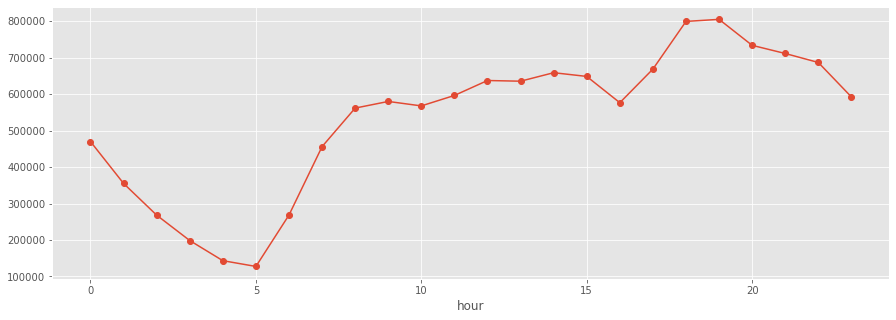

In [223]:
df.groupby('hour')['cnt'].sum().plot(x='hour', y=['cnt'], kind='line', style='-o', figsize=(15, 5))

- Peak: 18-19
- Off-peak: 5

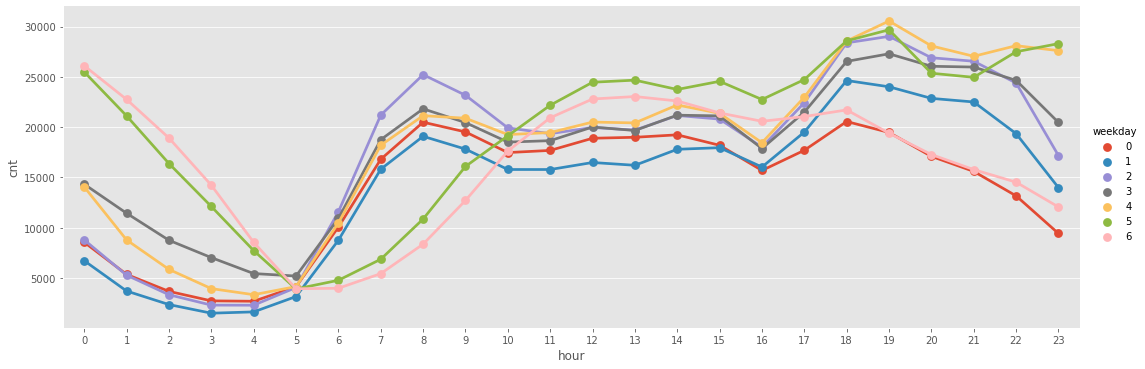

In [224]:
# plotly
df.groupby(['hour', 'weekday'])['cnt'].mean().unstack().iplot()
# sns
data = df.groupby(['weekday', 'hour']).mean()['cnt'].unstack(level=0).reset_index()
data = data.melt(id_vars='hour', value_vars=[0,1,2,3,4,5,6], value_name='cnt')
sns.factorplot(x='hour', y='cnt', hue='weekday', data=data, heights=5, aspect=3)

### Weekday/Weekend Trip Amount

<AxesSubplot:xlabel='hour'>

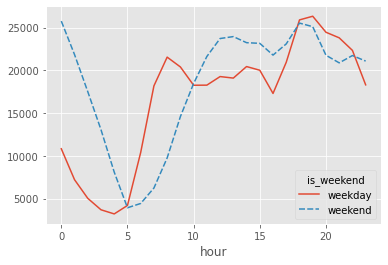

In [225]:
# plotly
df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int)
df.groupby(['hour', 'is_weekend'])['cnt'].mean().unstack().iplot()

# sns
average_df = df.groupby(['is_weekend', 'hour']).mean()['cnt'].unstack(level=0).rename(columns={0:'weekday',
                                                                                               1:'weekend'})
sns.lineplot(data=average_df)

### Day of week & Hour

<AxesSubplot:xlabel='weekday', ylabel='hour'>

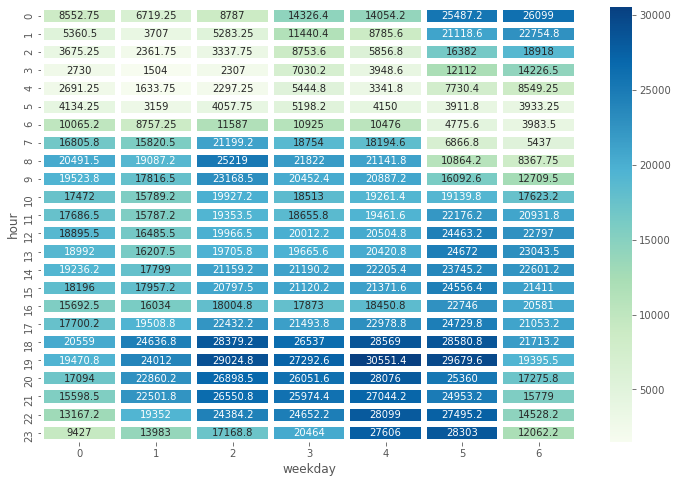

In [226]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.groupby(['hour', 'weekday'])['cnt'].mean().unstack(),
            lw=5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':10})

- Number of calls go up start from Friday evening (18-19)

### Box Plot

Text(0.5, 1.0, 'Hourly Box Plot (2015-01)')

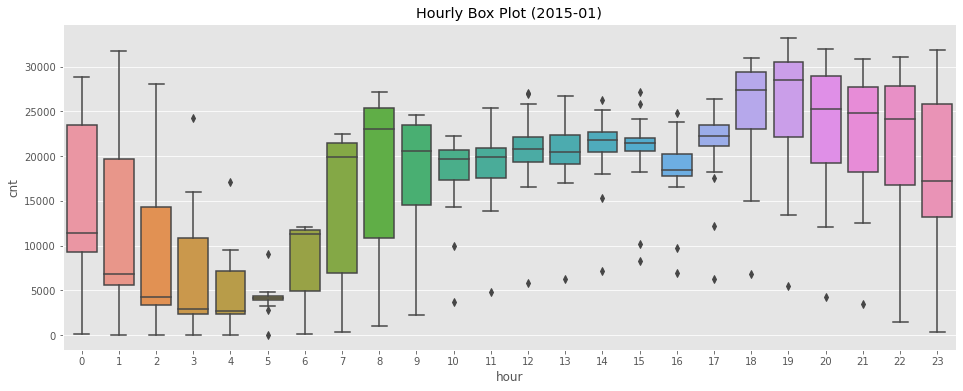

In [227]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='hour', y='cnt', data=df)
plt.title('Hourly Box Plot (2015-01)')

In [228]:
# plt.figure(figsize=(16, 6))
# sns.boxplot(x='hour', y='cnt', data=df[df['weeknum']==1])
# plt.title('Hourly Box Plot (2015-01 week 1)')

In [229]:
def visualize_hourly_boxplot_by_weeknum(df, y, weeknum):
    plt.figure(figsize=(16, 6))
    sns.boxplot(x='hour', y=y, data=df[df['weeknum']==weeknum])
    plt.title(f"Hourly Boxplot (2015 Week {weeknum:02})" )

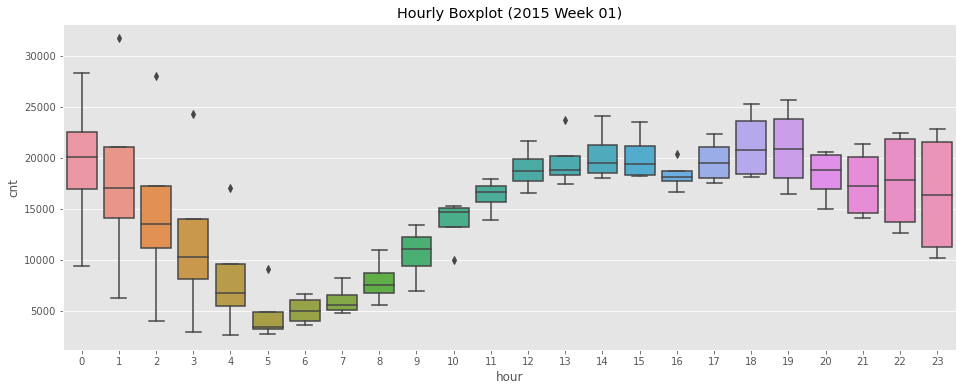

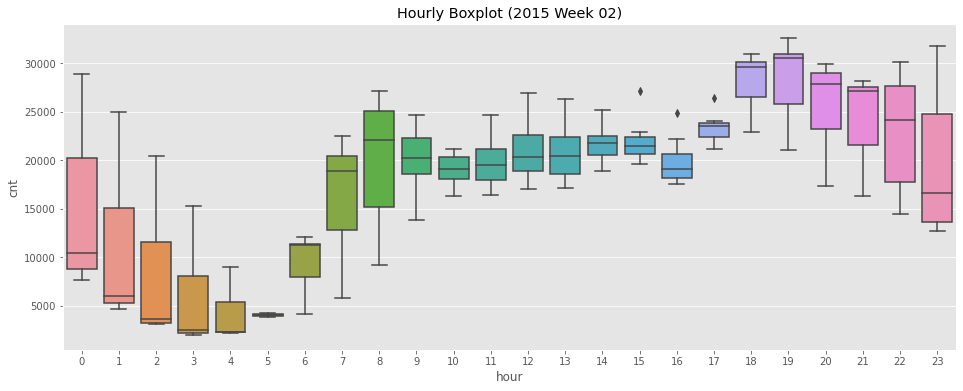

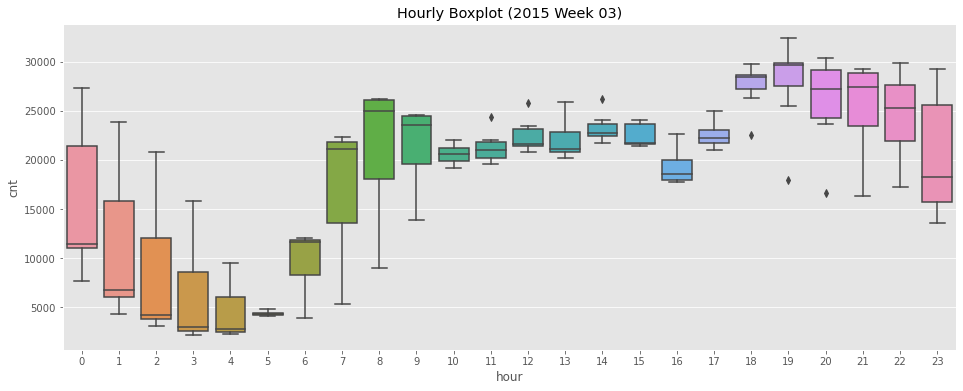

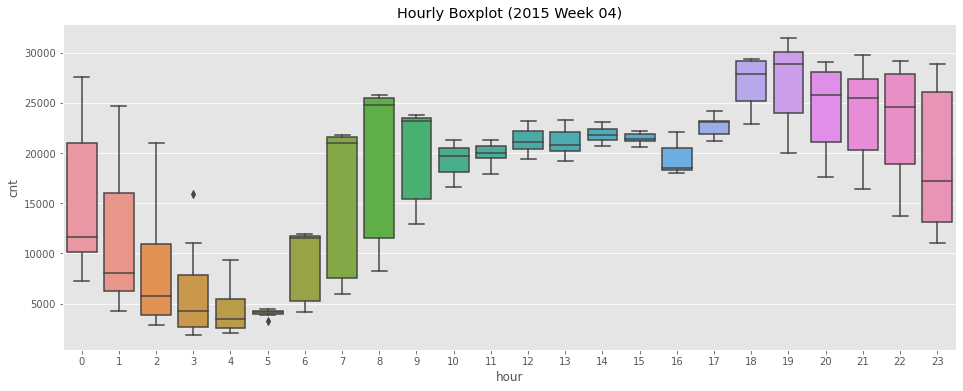

In [230]:
for week in range(1, 5):
    visualize_hourly_boxplot_by_weeknum(df, 'cnt', week)

Text(0.5, 1.0, 'is_weekend Box Plot (2015-01)')

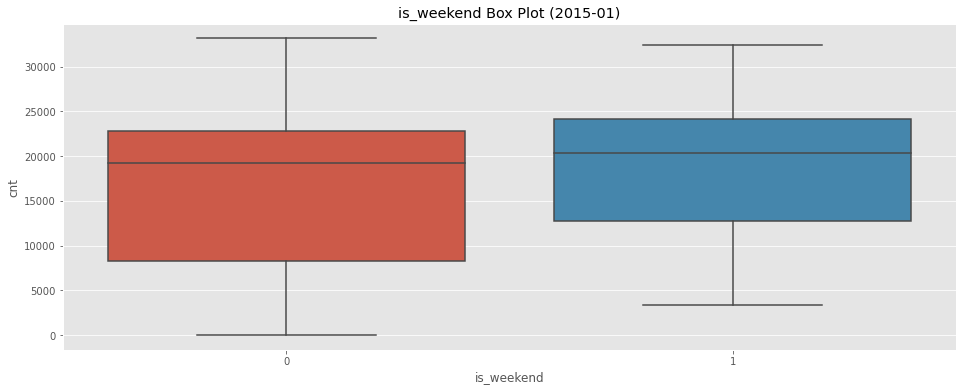

In [231]:
plt.figure(figsize=(16,6))
sns.boxplot(x='is_weekend', y='cnt', data=df)
plt.title('is_weekend Box Plot (2015-01)')

### Viloin Plot

In [232]:
weekday_dict={
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}

In [233]:
def visualize_violinplot_by_weekday(df, y, weekday):
    plt.figure(figsize=(16, 6))
    sns.violinplot(x='hour', y=y, hue='weekday', data=df[df['weekday'] == weekday][['hour', 'weekday', y]],
                    inner='quart')
    plt.title(f"{weekday_dict[weekday]}'s hourly violinplot {y}(2015-01)")

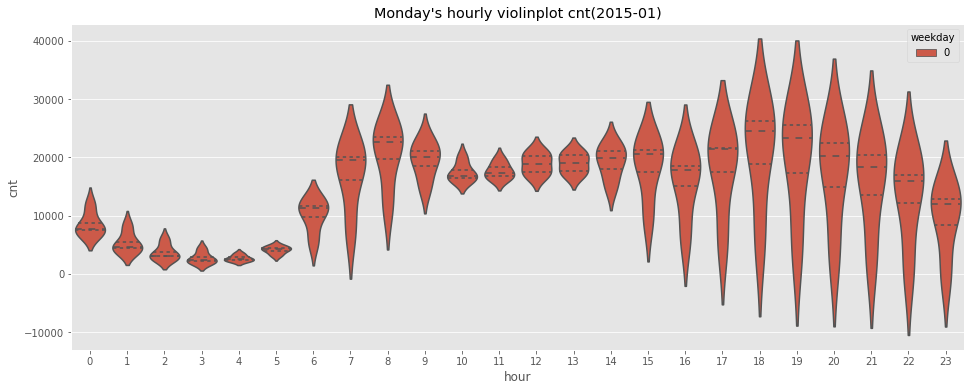

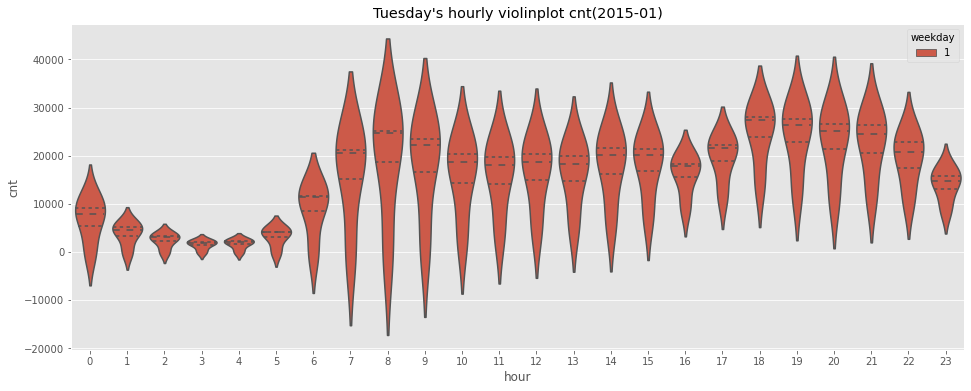

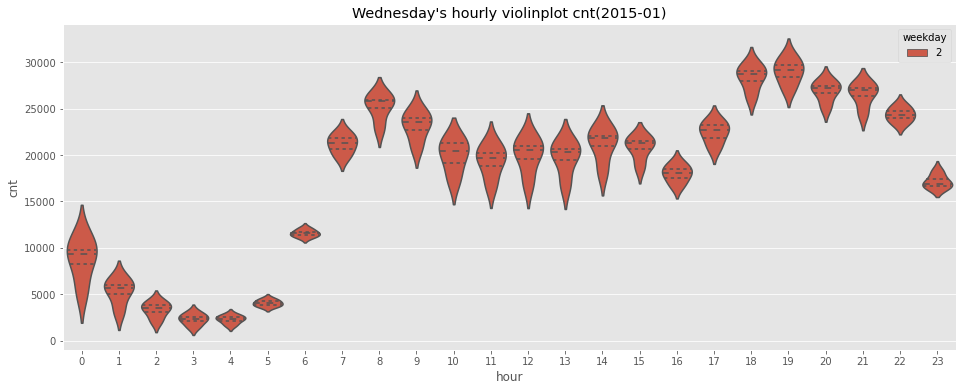

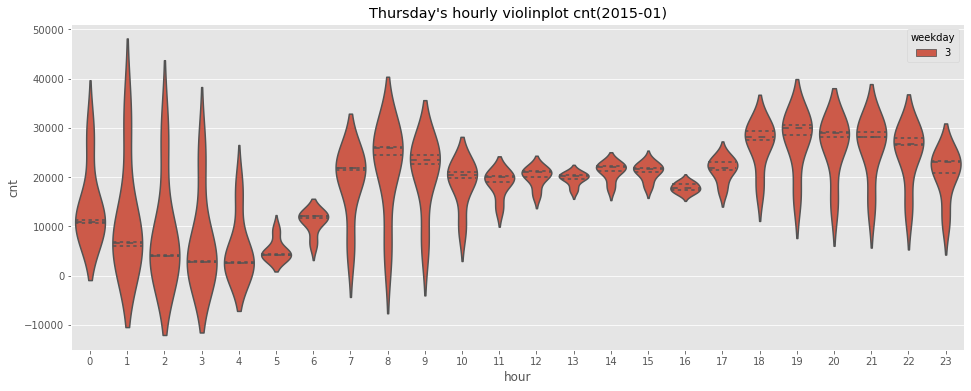

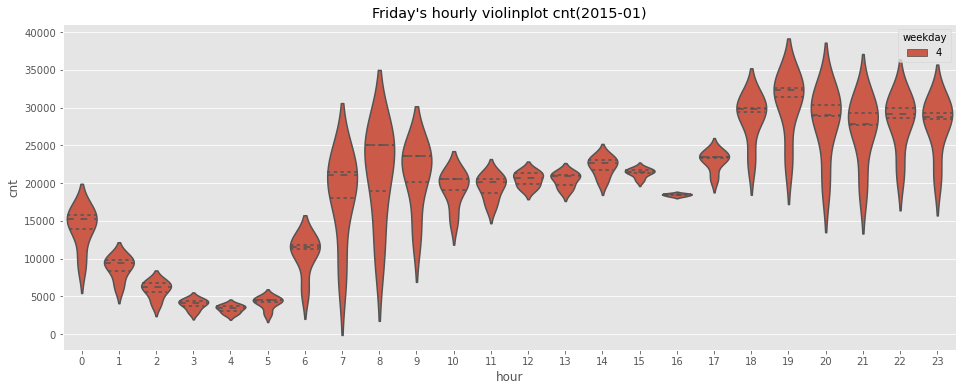

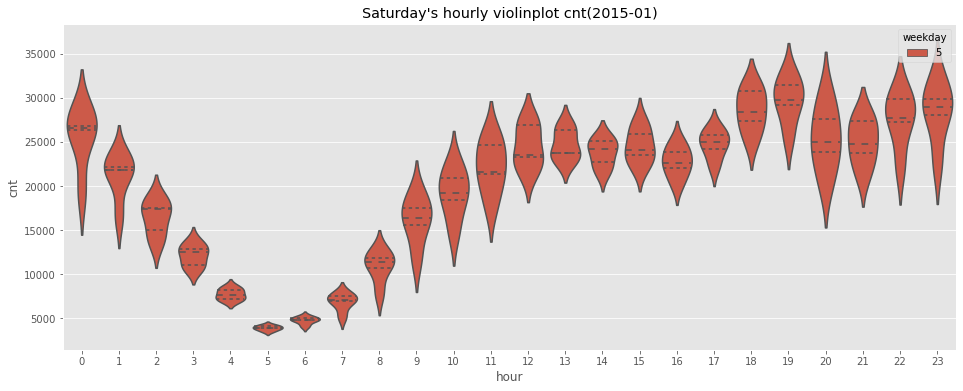

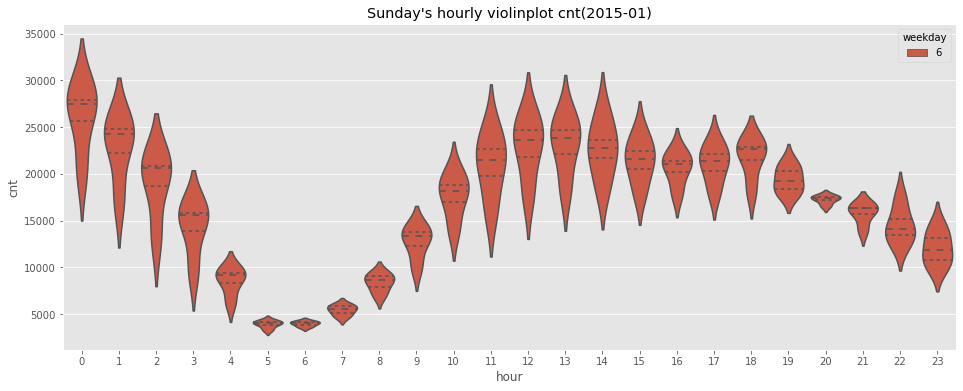

In [234]:
for weekday in range(0, 7):
    visualize_violinplot_by_weekday(df, 'cnt', weekday)

### Distribution of Trip Distance

In [235]:
%%time
trip_distance_query = """
SELECT
    floor(trip_distance/30)*30 as bucket_floor,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
ORDER BY bucket_floor
"""

trip_distance_query_log = """
SELECT
    floor(trip_distance/30)*30 as bucket_floor,
    log10(count(*)) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
ORDER BY bucket_floor
"""

distance_df = pd.read_gbq(query=trip_distance_query, dialect='standard', project_id='nyc-taxi-308416')
distance_log_df = pd.read_gbq(query=trip_distance_query_log, dialect='standard', project_id='nyc-taxi-308416')

CPU times: user 48.8 ms, sys: 0 ns, total: 48.8 ms
Wall time: 2.99 s


<AxesSubplot:xlabel='bucket_floor', ylabel='count'>

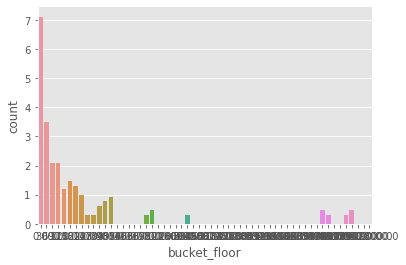

In [236]:
sns.barplot(x=distance_log_df['bucket_floor'], y=distance_log_df['count'])
# distance_log_df.set_index('bucket_floor').iplot(kind='bar')

### Demand for Long Distance VS Short Distance

In [237]:
short_trip_query = """
SELECT
    EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
    EXTRACT(HOuR FROM dropoff_datetime) as dropoff_hour,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
AND trip_distance < 30
GROUP BY pickup_hour, dropoff_hour
"""

short_trip_df = pd.read_gbq(query=short_trip_query, dialect='standard', project_id='nyc-taxi-308416')

In [238]:
long_trip_query = """
SELECT
    EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
    EXTRACT(HOuR FROM dropoff_datetime) as dropoff_hour,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
WHERE EXTRACT(MONTH from pickup_datetime) = 1
AND trip_distance >= 30
GROUP BY pickup_hour, dropoff_hour
"""

long_trip_df = pd.read_gbq(query=long_trip_query, dialect='standard', project_id='nyc-taxi-308416')

In [239]:
trip_df = short_trip_df.merge(long_trip_df, on=['pickup_hour', 'dropoff_hour'], suffixes=["_short", "_long"]) \
    .rename(columns={'count_short':'short_trips', 'count_long':'long_trips'})

In [240]:
trip_df_pickup = trip_df.groupby(['pickup_hour'], as_index=False).agg({'short_trips': 'sum', 'long_trips': 'sum'}) \
                                                                                    .sort_values(by='pickup_hour')

trip_df_dropoff = trip_df.groupby(['dropoff_hour'], as_index=False).agg({'short_trips': 'sum', 'long_trips': 'sum'}) \
                                                                                    .sort_values(by='dropoff_hour')

In [241]:
trip_df_pickup.head()

,pickup_hour,short_trips,long_trips
0,0,469713,146
1,1,354890,94
2,2,267918,89
3,3,198414,59
4,4,143109,62


In [242]:
trip_df_dropoff.head()

,dropoff_hour,short_trips,long_trips
0,0,494882,149
1,1,377049,147
2,2,284456,100
3,3,208594,81
4,4,156581,57


In [243]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # Set theta for 24hour clock format
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # set bin, width for each plot
    width = 2*np.pi / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor='#999999')

    # label
    ax.set_theta_zero_location('N')
    # direction
    ax.set_theta_direction(-1)

    # Setting Label
    ax.set_xticks(theta)
    ticks = [" {}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [244]:
def diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

    ax = plt.subplot(2,2,1, polar=True)
    radii = np.array(trip_df_pickup['short_trips'].tolist(), dtype='int64')
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, '#dc143c')

    ax = plt.subplot(2,2,2, polar=True)
    radii = np.array(trip_df_pickup['long_trips'].tolist(), dtype='int64')
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, '#56B4E9')

    ax = plt.subplot(2,2,3, polar=True)
    radii = np.array(trip_df_dropoff['short_trips'].tolist(), dtype='int64')
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, '#dc143c')

    ax = plt.subplot(2,2,4, polar=True)
    radii = np.array(trip_df_dropoff['long_trips'].tolist(), dtype='int64')
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, '#56B4E9')

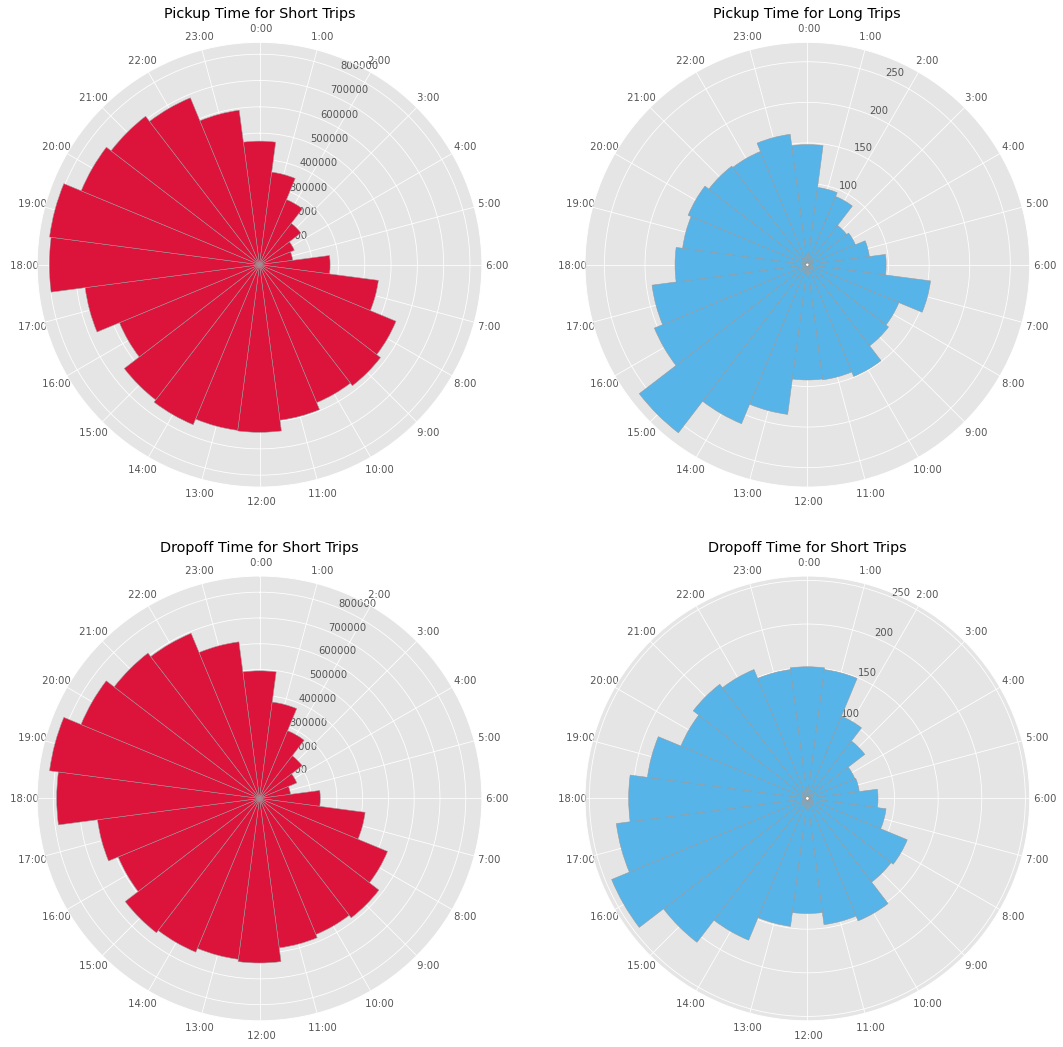

In [245]:
diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff)

- Peak Time:
    - Short Trip: 18:00 - 22:00
    - Long Trip: 13:00 - 15:30

# NYC Taxi Traffic EDA 2 - Region

This part of EDA focuses on exploring the NYC Taxi Traffic from regional perspective. Find out which area has the highest or lowest traffic.
- Google provides geo_us_boundaries so that I can find the following zip codes based on the longtitude and latitude

In [246]:
%%time
query = """

WITH base_data AS (
    SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
),
     temp AS (
         SELECT nyc_taxi.*, gis.*
             FROM (
                      SELECT *
                          FROM base_data
                          WHERE pickup_latitude <= 90
                            AND pickup_latitude >= -90
                  ) AS nyc_taxi
         JOIN (
         SELECT zip_code, state_code, state_name, city, county, zip_code_geom
         FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
         WHERE state_code = 'NY'
         ) AS gis
         ON st_contains(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
     )

SELECT zip_code,
       city,
       ST_ASTEXT(zip_code_geom)              AS zip_code_geom,
       DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
       COUNT(*)                              AS cnt
FROM temp
GROUP BY zip_code, city, zip_code_geom, pickup_hour
ORDER BY pickup_hour

"""

df2 = pd.read_gbq(query=query, dialect='standard', project_id=project_id)

INFO - pandas_gbq.gbq - Total time taken 58.9 s.
Finished at 2021-04-01 19:32:27.


CPU times: user 4.48 s, sys: 347 ms, total: 4.83 s
Wall time: 58.9 s


In [247]:
df2.head()

,zip_code,city,zip_code_geom,pickup_hour,cnt
0,10029,New York city,"POLYGON((-73.955528 40.788245, -73.955778 40.7...",2015-01-01,204
1,10024,New York city,"POLYGON((-73.98814 40.781409, -73.987414 40.78...",2015-01-01,869
2,10013,New York city,"POLYGON((-74.016302 40.720758, -74.016381 40.7...",2015-01-01,689
3,10003,New York city,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",2015-01-01,1809
4,10128,New York city,"MULTIPOLYGON(((-73.939508 40.779224, -73.93963...",2015-01-01,706


In [248]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zip_code       87020 non-null  object        
 1   city           87020 non-null  object        
 2   zip_code_geom  87020 non-null  object        
 3   pickup_hour    87020 non-null  datetime64[ns]
 4   cnt            87020 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.3+ MB


### Which Zip Code has the highest trip?

In [249]:
zip_code_agg_df = df2.groupby(['zip_code', 'zip_code_geom'])[['cnt']].sum().reset_index()

In [250]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831


In [251]:
zip_code_agg_df['percent'] = (zip_code_agg_df[['cnt']]/df2[['cnt']].sum()).round(3).rename(columns={'cnt':'percent'}).reset_index()['percent']

In [252]:
zip_code_agg_df.head(10)

,zip_code,zip_code_geom,cnt,percent
0,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",627563,0.051
1,10002,"POLYGON((-73.997504 40.714069, -73.9973 40.713...",234527,0.019
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
3,10004,"MULTIPOLYGON(((-74.018008 40.705935, -74.01801...",59700,0.005
4,10005,"POLYGON((-74.012508 40.706767, -74.0124 40.706...",52454,0.004
5,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",35708,0.003
6,10007,"POLYGON((-74.013382 40.714408, -74.0137 40.713...",87112,0.007
7,10009,"POLYGON((-73.988451 40.723277, -73.988643 40.7...",252903,0.021
8,10010,"POLYGON((-73.993739 40.741617, -73.994028 40.7...",387908,0.031
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053


In [253]:
zip_code_agg_df.tail()

,zip_code,zip_code_geom,cnt,percent
369,13656,"POLYGON((-76.067267 44.140696, -76.067236 44.1...",1,0.0
370,13691,"POLYGON((-75.88536 44.23349, -75.88501 44.2310...",1,0.0
371,14072,"MULTIPOLYGON(((-78.935536 42.965442, -78.93553...",1,0.0
372,14527,"MULTIPOLYGON(((-77.121905 42.624718, -77.12188...",1,0.0
373,14801,"POLYGON((-77.442016 42.140918, -77.44193 42.14...",1,0.0


In [254]:
filter_agg_df = zip_code_agg_df[zip_code_agg_df['percent'] > 0]

In [255]:
filter_agg_df['cnt'].sum()

12197865

In [256]:
filter_zip_code = filter_agg_df['zip_code'].to_list()

In [257]:
filter_agg_df.tail(10)

,zip_code,zip_code_geom,cnt,percent
195,11206,"POLYGON((-73.95733 40.700904, -73.957457 40.70...",9628,0.001
200,11211,"MULTIPOLYGON(((-73.955603 40.724041, -73.95567...",61907,0.005
204,11215,"POLYGON((-74.000995 40.654067, -74.002144 40.6...",12420,0.001
206,11217,"POLYGON((-73.990424 40.682694, -73.990867 40.6...",22778,0.002
211,11222,"POLYGON((-73.962672 40.736446, -73.962668 40.7...",13370,0.001
219,11231,"POLYGON((-74.02002 40.677049, -74.019892 40.67...",14605,0.001
226,11238,"POLYGON((-73.973648 40.687303, -73.973374 40.6...",9456,0.001
245,11371,"POLYGON((-73.889077 40.773574, -73.889424 40.7...",247923,0.020
250,11377,"POLYGON((-73.925808 40.73589, -73.925834 40.73...",13416,0.001
273,11430,"POLYGON((-73.832705 40.665406, -73.831781 40.6...",233390,0.019


In [258]:
filter_agg_df.sort_values(by='cnt', ascending=False)

,zip_code,zip_code_geom,cnt,percent
16,10019,"POLYGON((-74.003568 40.763799, -74.003767 40.7...",817267,0.066
2,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",704598,0.057
19,10022,"POLYGON((-73.977201 40.758538, -73.977655 40.7...",679831,0.055
13,10016,"POLYGON((-73.987298 40.744682, -73.987746 40.7...",663540,0.054
9,10011,"POLYGON((-74.012285 40.74387, -74.012359 40.74...",647831,0.053
...,...,...,...,...
194,11205,"POLYGON((-73.980649 40.701561, -73.980729 40.7...",8437,0.001
54,10167,"POLYGON((-73.975352 40.755303, -73.975807 40.7...",8186,0.001
45,10112,"POLYGON((-73.980426 40.759899, -73.980886 40.7...",8135,0.001
60,10173,"POLYGON((-73.979937 40.754783, -73.980395 40.7...",7966,0.001


In [259]:
filter_agg_df.to_csv('zip_code_ratio.csv', index=False)

### Using kepler.gl for visualization

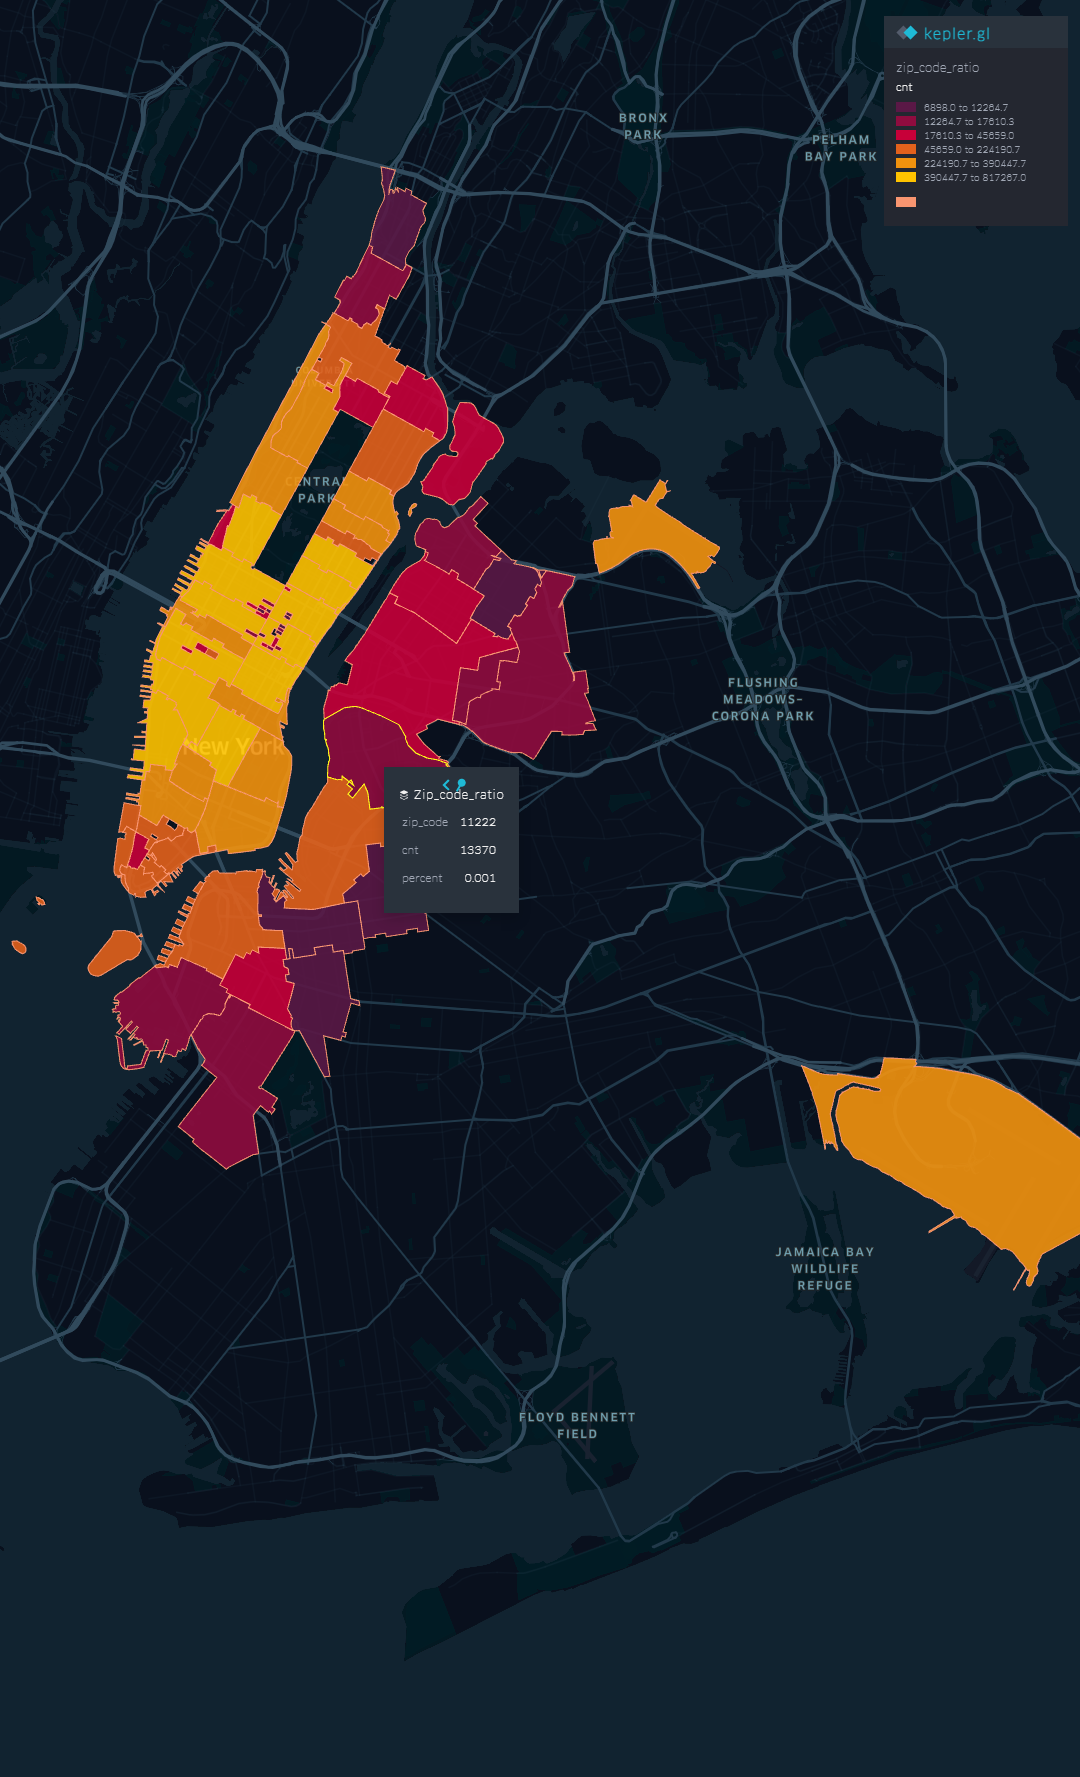

In [260]:
zip_df = df2[['zip_code', 'zip_code_geom', 'pickup_hour', 'cnt']]
zip_df['date'] = zip_df['pickup_hour'].dt.date

<AxesSubplot:xlabel='pickup_hour'>

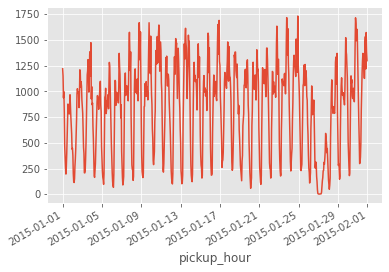

In [261]:
zip_df[zip_df['zip_code'] == '10001'].set_index('pickup_hour')['cnt'].plot()

### Trip Box Plot based on daily & zip code

In [262]:
filter_zip_df = zip_df[zip_df['zip_code'].isin(filter_zip_code)]
filter_zip_daily_df = filter_zip_df.groupby(['zip_code', 'date'])[['cnt']].sum().reset_index()

In [263]:
# Plotly
filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code').iplot(kind='box', x='zip_code')

<AxesSubplot:xlabel='zip_code', ylabel='cnt'>

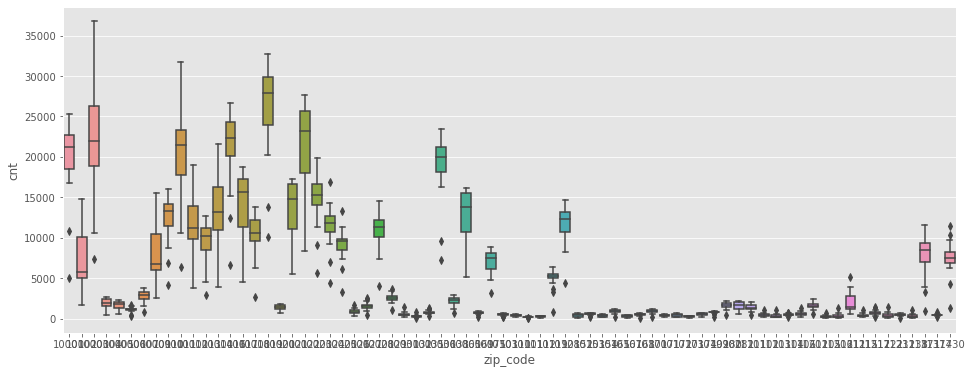

In [264]:
# seaborn
plt.figure(figsize=(16, 6))
sns.boxplot(x='zip_code', y='cnt', data=filter_zip_daily_df)

In [265]:
filter_zip_df[filter_zip_df['zip_code'] == '10001']

,zip_code,zip_code_geom,pickup_hour,cnt,date
53,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 00:00:00,1221,2015-01-01
189,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 01:00:00,1151,2015-01-01
432,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 02:00:00,939,2015-01-01
632,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 03:00:00,997,2015-01-01
662,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-01 04:00:00,794,2015-01-01
...,...,...,...,...,...
86504,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 19:00:00,1534,2015-01-31
86578,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 20:00:00,1219,2015-01-31
86744,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 21:00:00,1574,2015-01-31
86765,10001,"POLYGON((-74.00828 40.750272, -74.008255 40.75...",2015-01-31 22:00:00,1385,2015-01-31


<AxesSubplot:xlabel='zip_code', ylabel='date'>

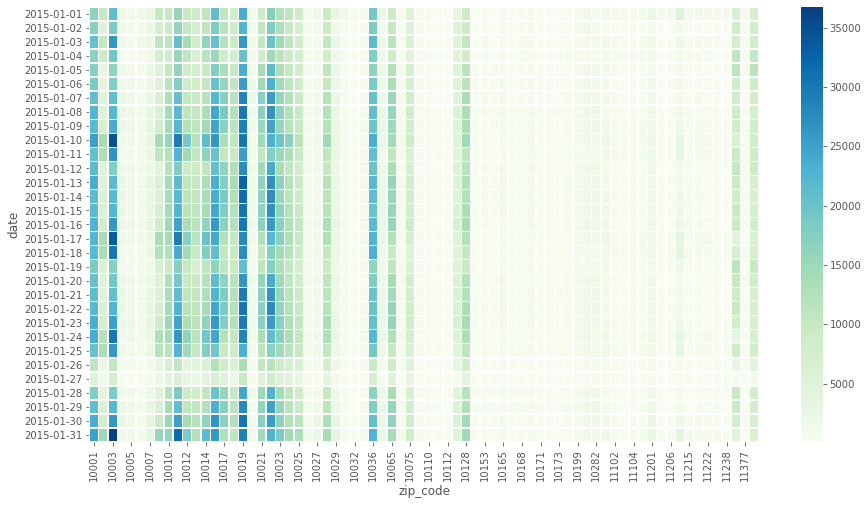

In [266]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_daily_df.pivot_table('cnt', index='date', columns='zip_code'), lw=.5, cmap='GnBu')

### Hourly & Zip Code

In [267]:
filter_zip_df['hour'] = filter_zip_df['pickup_hour'].dt.hour
filter_zip_df.head(5)

,zip_code,zip_code_geom,pickup_hour,cnt,date,hour
0,10029,"POLYGON((-73.955528 40.788245, -73.955778 40.7...",2015-01-01,204,2015-01-01,0
1,10024,"POLYGON((-73.98814 40.781409, -73.987414 40.78...",2015-01-01,869,2015-01-01,0
2,10013,"POLYGON((-74.016302 40.720758, -74.016381 40.7...",2015-01-01,689,2015-01-01,0
3,10003,"POLYGON((-73.999366 40.731323, -73.999604 40.7...",2015-01-01,1809,2015-01-01,0
4,10128,"MULTIPOLYGON(((-73.939508 40.779224, -73.93963...",2015-01-01,706,2015-01-01,0


<AxesSubplot:xlabel='zip_code', ylabel='hour'>

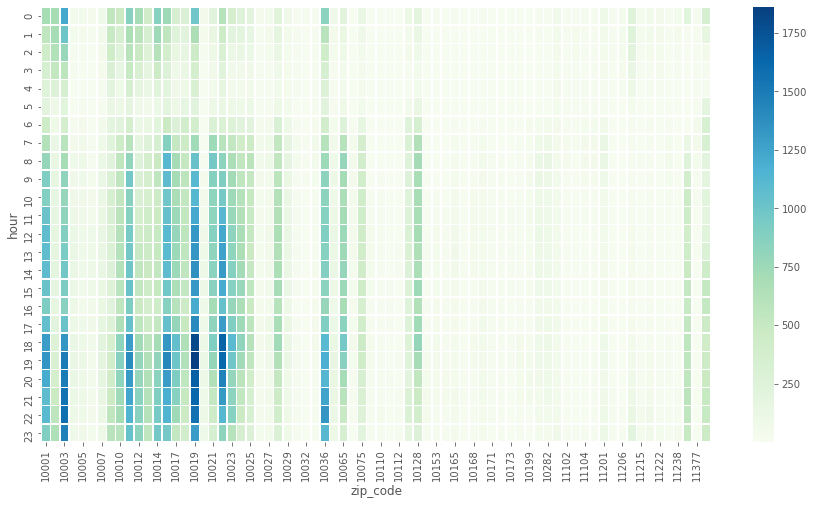

In [268]:
plt.figure(figsize=(15,8))
sns.heatmap(filter_zip_df.pivot_table('cnt', index='hour', columns='zip_code'), lw=.5, cmap='GnBu')

## Date Preprocessing

### Time

In [269]:
%%time
query = """
SELECT *,
       EXTRACT(MONTH FROM pickup_hour)                       AS month,
       EXTRACT(DAY FROM pickup_hour)                         AS day,
       CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) - 1 AS weeekday,
       EXTRACT(HOUR FROM pickup_hour)                        AS hour,
       CASE
           WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7)
               THEN 1
           ELSE 0
           END                                               AS is_weekend
    FROM (
             SELECT DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
                    COUNT(*)                              AS cnt
                 FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
                 WHERE EXTRACT(MONTH FROM pickup_datetime) = 1
                 GROUP BY pickup_hour
         )
    ORDER BY pickup_hour
"""
df3 = pd.read_gbq(query=query, dialect='standard', project_id=project_id)

CPU times: user 40.4 ms, sys: 31 µs, total: 40.5 ms
Wall time: 1.37 s


### Python Way

In [270]:
# extract_query = """
# SELECT 
#     DATETIME_TRUNC(pickup_datetime, hour) AS pickup_hour,
#     count(*) AS cnt
# FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
# WHERE EXTRACT(MONTH from pickup_datetime) = 1
# GROUP BY pickup_hour
# ORDER BY pickup_hour
# """

# df3 = pd.read_gbq(query=extract_query, dialect='standard', project_id=project_id)

In [271]:
# df3['month'] = df3['pickup_hour'].dt.month
# df3['day'] = df3['pickup_hour'].dt.day
# df3['weekday'] = df3['pickup_hour'].dt.weekday
# df3['hour'] = df3['pickup_hour'].dt.hour
# df3['is_weekend'] = (df3['pickup_hour'].dt.weekday // 5 == 1).astype(int)

### BigQuery GIS - Reverse Geocoding for converting longitude & latitude into zip_code

In [272]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""
base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=project_id)

INFO - pandas_gbq.gbq - Total time taken 7.07 s.
Finished at 2021-04-01 19:32:39.


CPU times: user 2.16 s, sys: 115 ms, total: 2.28 s
Wall time: 7.08 s


In [273]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
87015,11219,2015-01-31 23:00:00,1,31,5,23,1,1
87016,11218,2015-01-31 23:00:00,1,31,5,23,1,8
87017,10456,2015-01-31 23:00:00,1,31,5,23,1,3
87018,11210,2015-01-31 23:00:00,1,31,5,23,1,1
87019,10167,2015-01-31 23:00:00,1,31,5,23,1,1


### Categorical - One Hot Encoding & Label Encoding

#### One Hot Encoding

In [274]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])

OneHotEncoder(handle_unknown='ignore')

In [275]:
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
oh_feature_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+enc.categories_[0])], axis=1)
oh_feature_df.head(3)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,11373,2015-01-01,1,1,3,0,0,14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10024,2015-01-01,1,1,3,0,0,869,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11237,2015-01-01,1,1,3,0,0,38,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [276]:
oh_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Columns: 382 entries, zip_code to zip_code_14801
dtypes: datetime64[ns](1), float64(374), int64(6), object(1)
memory usage: 253.6+ MB


In [277]:
# le = LabelEncoder()
# le.fit(base_df['zip_code'])
# base_df['zip_code_le'] = le.transform(base_df['zip_code'])

## Linear Regression - Baseline Model (Part 1)

In [278]:
from sklearn.linear_model import LinearRegression
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [279]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=project_id)

INFO - pandas_gbq.gbq - Total time taken 6.82 s.
Finished at 2021-04-01 19:32:47.


CPU times: user 2.19 s, sys: 116 ms, total: 2.3 s
Wall time: 6.82 s


In [280]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

In [281]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10280,2015-01-01,1,1,3,0,0,54
1,10013,2015-01-01,1,1,3,0,0,689
2,11369,2015-01-01,1,1,3,0,0,14
3,11788,2015-01-01,1,1,3,0,0,1
4,10040,2015-01-01,1,1,3,0,0,13


### The distribution of Target feature

<AxesSubplot:xlabel='cnt', ylabel='Density'>

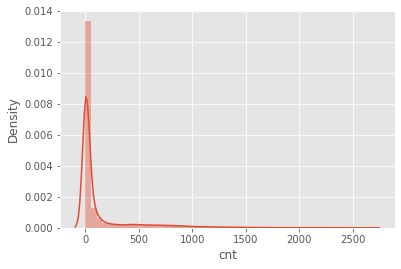

In [282]:
sns.distplot(base_df['cnt'])

<AxesSubplot:xlabel='cnt', ylabel='Density'>

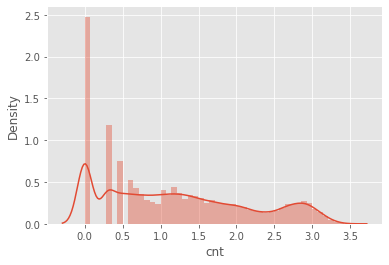

In [283]:
# Log Transformation
sns.distplot(np.log10(base_df['cnt']))

In [284]:
# Using Widget
def visualize_dist_by_zipcode(df, log=False):
    def view_images(zip_code):
        if log:
            data = np.log10(df.loc[df['zip_code'] == str(zip_code)]['cnt'])
        else:
            data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        ax = sns.distplot(data)
        ax.set_title(f'log is {log}, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

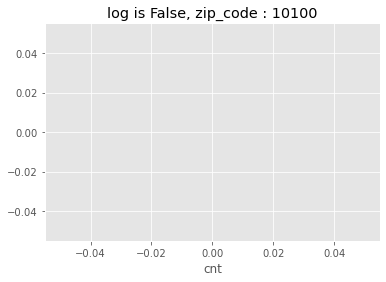

In [285]:
visualize_dist_by_zipcode(ohe_df)

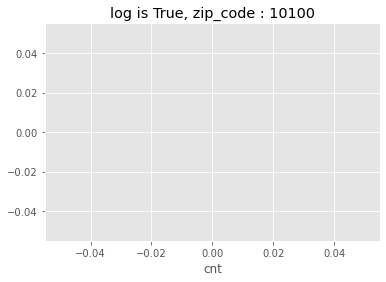

In [286]:
visualize_dist_by_zipcode(base_df, log=True)

In [287]:
def visualize_dist_by_zipcode_at_the_same_time(df):
    def view_images(zip_code):
        fig, axs = plt.subplots(ncols=2, figsize=(15,5))
        
        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        ax1 = sns.distplot(raw_data, ax=axs[0])
        ax2 = sns.distplot(log_data, ax=axs[1])
        ax1.set_title(f'log is False, zip_code : {zip_code}')
        ax2.set_title(f'log is True, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

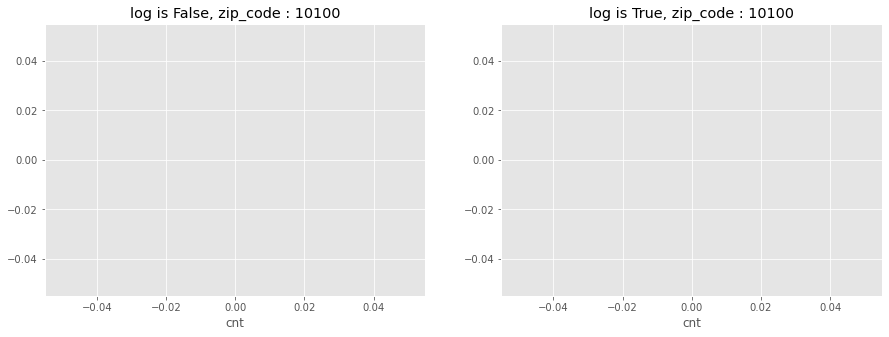

In [288]:
visualize_dist_by_zipcode_at_the_same_time(base_df)

In [289]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

### Train / Test Split
- Can't do Random Sampling on Time Series Data
- Train: Past data
- Test: Future data

In [290]:
def split_train_and_test(df, date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [291]:
def split_train_and_test_period(df, period):
    criteria = (max(df['pickup_hour']) - pd.Timedelta(days=period)).date()
    train_df = df[df['pickup_hour'] < criteria]
    test_df = df[df['pickup_hour'] >= criteria]
    return train_df, test_df

In [292]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [293]:
train_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,10280,2015-01-01,1,1,3,0,0,54,1.732394
1,10013,2015-01-01,1,1,3,0,0,689,2.838219
2,11369,2015-01-01,1,1,3,0,0,14,1.146128
3,11788,2015-01-01,1,1,3,0,0,1,0.000000
4,10040,2015-01-01,1,1,3,0,0,13,1.113943


In [294]:
test_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65118,10172,2015-01-24,1,24,5,0,1,19,1.278754
65119,10171,2015-01-24,1,24,5,0,1,13,1.113943
65120,11206,2015-01-24,1,24,5,0,1,68,1.832509
65121,10019,2015-01-24,1,24,5,0,1,1714,3.234011
65122,11040,2015-01-24,1,24,5,0,1,2,0.301030


In [295]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [296]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [297]:
X_train = train_df.copy()
X_test = test_df.copy()

## Linear Regression - Baseline Model (Part 2)

In [298]:
# Without One Hot Encoding
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train_log)
pred = lr_reg.predict(X_test)
pred

array([1.41494959, 1.41581239, 0.52281409, ..., 0.84251135, 0.70705171,
       0.65096969])

In [299]:
test_df['pred_log'] = pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [300]:
def evaluation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [301]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


<AxesSubplot:>

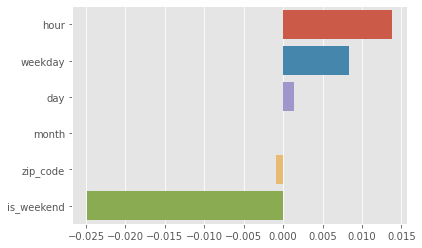

In [302]:
coef = pd.Series(lr_reg.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [303]:
# With One hot Encoding
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

X_train = train_df.copy()
X_test = test_df.copy()

In [304]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train_log)
pred = lr_reg.predict(X_test)
pred

array([0.9356308 , 0.94685364, 0.67543793, ..., 0.44916534, 0.78990936,
       0.64772797])

In [305]:
test_df['pred_log'] = pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [306]:
test_df.head(5)

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.935631,8.622452,1.278754,19
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.946854,8.848174,1.113943,13
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.675438,4.736286,1.832509,68
65121,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.830505,676.870164,3.234011,1714
65122,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.125366,0.749262,0.301030,2


In [307]:
# Sometimes you might get an error due to Infinity. Check is necessary
test_df = test_df[np.isfinite(test_df).all(1)]

In [308]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.742635,66.943882,27020.931607


<AxesSubplot:>

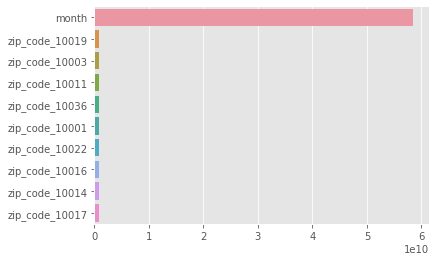

In [309]:
coef = pd.Series(lr_reg.coef_, index=X_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## Sacred
- [Sacred Github](https://github.com/IDSIA/sacred)
- Sacred is a tool to help you configure, organize, log and reproduce experiments developed at IDSIA
- Sacred's Main mechanisms:
    - ConfigScopes
    - Config Injection
    - Command-line interface
    - Observers
    - Automatic seeding

In [310]:
# !pip3 install sacred

In [311]:
from sacred import Experiment
from sacred.observers import FileStorageObserver

In [312]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# Create an experiment_dir folder and save with FileStorageObserver
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir):
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### Preparation

In [313]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=project_id)

INFO - pandas_gbq.gbq - Total time taken 8.05 s.
Finished at 2021-04-01 19:33:00.


CPU times: user 2.17 s, sys: 131 ms, total: 2.3 s
Wall time: 8.05 s


### Feature Engineering

In [314]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+enc.categories_[0])], axis=1)
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])

In [315]:
def split_train_and_test(df, date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test Split

In [316]:
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')

In [317]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [318]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [319]:
y_true = y_test_raw.values.copy()

In [320]:
x_train = train_df.copy()
x_test = test_df.copy()

In [321]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

### Experiment Configuration

In [322]:
@ex.config
def config():
    fit_intercept=True
    normalize=False

In [323]:
@ex.capture
def get_model(fit_intercept, normalize):
    return LinearRegression(fit_intercept, normalize)

In [324]:
@ex.main
def run(_log, _run):
    lr_reg = get_model()
    lr_reg.fit(x_train, y_train_raw)
    pred = lr_reg.predict(x_test)
    # Save in Log file
    _log.info("Predict End")
    score = evaluation(y_test_raw, pred)
    _run.log_scalar('model_name', lr_reg.__class__.__name__)
    
    # Metrics
    _run.log_scalar('metrics', score)
    
    # Result
    return score.to_dict()

In [325]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "1"
INFO - run - Predict End
INFO - nyc-demand-prediction - Result: {'mape': {'score': 18866538046.06298}, 'mae': {'score': 192858008.35280436}, 'mse': {'score': 3.5418556533263045e+19}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [326]:
experiment_result.config

{'fit_intercept': True, 'normalize': False, 'seed': 550995102}

In [327]:
# 1) _run.log_scalar -> save metrics
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    output_df = output_df.round(2)
    return output_df

In [328]:
# 2) #ex.main 
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/run.json') as json_file:
        json_data = json.load(json_file)
    output = pd.DataFrame(json_data['result'])
    return output

In [329]:
parsing_output(1)

,mae,mape,mse
score,1.928580e+08,1.886654e+10,3.541856e+19


## XGBoost Regressor

In [330]:
# !pip3 install xgboost

In [331]:
from xgboost import XGBRegressor

In [332]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=project_id)

INFO - pandas_gbq.gbq - Total time taken 7.25 s.
Finished at 2021-04-01 19:33:10.


CPU times: user 2.23 s, sys: 158 ms, total: 2.38 s
Wall time: 7.26 s


### Data Preprocessing

In [333]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [334]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [335]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [336]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [337]:
x_train = train_df.copy()
x_test = test_df.copy()

### Modeling

In [338]:
@ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [339]:
@ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [340]:
@ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    # Save in Log file
    _log.info("Predict End")
    score = evaluation(y_test_raw, xgb_pred)
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)
    
    # Metrics
    _run.log_scalar('metrics', score)
    
    # Result
    return score.to_dict()

In [341]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "2"
INFO - run - Predict End
INFO - nyc-demand-prediction - Result: {'mape': {'score': 538.5201561766146}, 'mae': {'score': 57.67873599873819}, 'mse': {'score': 16512.3302373418}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [342]:
experiment_result.config

{'fit_intercept': True,
 'normalize': False,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 580034867}

In [343]:
parsing_output(2)

,mae,mape,mse
score,57.678736,538.520156,16512.330237


<AxesSubplot:>

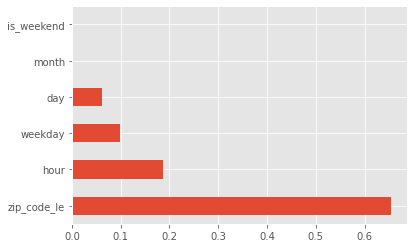

In [344]:
feature_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feature_importances.nlargest(15).plot(kind='barh')

## Lightgbm

In [345]:
# pip install lightgbm

In [346]:
from lightgbm import LGBMRegressor

### Modeling

In [347]:
@ex.config
def config():
    num_leaves=31
    learning_rate=0.1
    n_estimators=100

In [348]:
@ex.capture
def get_model(num_leaves,learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators)

In [349]:
@ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)
    lgbm_pred = lgbm_reg.predict(x_test)
    # Save in Log file
    _log.info("Predict End")
    score = evaluation(y_test_raw, lgbm_pred)
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)
    
    # Metrics
    _run.log_scalar('metrics', score)
    
    # Result
    return score.to_dict()

In [350]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "3"
INFO - run - Predict End
INFO - nyc-demand-prediction - Result: {'mape': {'score': 421.6856972338652}, 'mae': {'score': 48.24149103960721}, 'mse': {'score': 13755.6848899755}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [351]:
experiment_result.config

{'fit_intercept': True,
 'normalize': False,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'seed': 559431120}

In [352]:
parsing_output(3)

,mae,mape,mse
score,48.241491,421.685697,13755.68489


<AxesSubplot:>

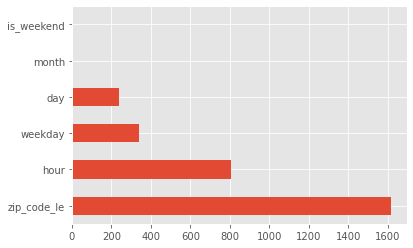

In [353]:
feature_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feature_importances.nlargest(15).plot(kind='barh')

## Random Forest Regressor

In [354]:
from sklearn.ensemble import RandomForestRegressor

### Modeling

In [355]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [356]:
@ex.capture
def get_model(n_estimators,n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)

In [357]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    # Save in Log file
    _log.info("Predict End")
    score = evaluation(y_test_raw, rf_pred)
    _run.log_scalar('model_name', rf_reg.__class__.__name__)
    
    # Metrics
    _run.log_scalar('metrics', score)
    
    # Result
    return score.to_dict()

In [358]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "4"
INFO - run - Predict End
INFO - nyc-demand-prediction - Result: {'mape': {'score': 186.2330775353791}, 'mae': {'score': 35.250118710620036}, 'mse': {'score': 12155.350074422426}}
INFO - nyc-demand-prediction - Completed after 0:00:01


In [359]:
experiment_result.config

{'fit_intercept': True,
 'normalize': False,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 10,
 'n_jobs': -1,
 'num_leaves': 31,
 'seed': 369257181}

In [360]:
parsing_output(4)

,mae,mape,mse
score,35.250119,186.233078,12155.350074


<AxesSubplot:>

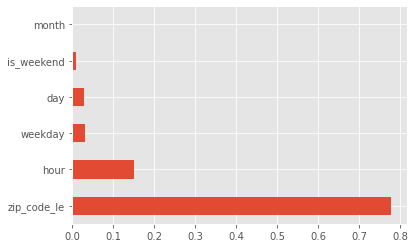

In [361]:
feature_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feature_importances.nlargest(15).plot(kind='barh')

## Result Analysis

### XGBoost

In [362]:
parsing_output(2)

,mae,mape,mse
score,57.678736,538.520156,16512.330237


### LightGBM

In [363]:
parsing_output(3)

,mae,mape,mse
score,48.241491,421.685697,13755.68489


### RF

In [364]:
parsing_output(4)

,mae,mape,mse
score,35.250119,186.233078,12155.350074


In [157]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_le
65118,1,24,5,0,1,59
65119,1,24,5,0,1,58
65120,1,24,5,0,1,195
65121,1,24,5,0,1,16
65122,1,24,5,0,1,180


### Restore Data
- Label Encoding, Deleted Data, Datetime -> reverse encoding again

In [365]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred

In [366]:
test_df['year'] = 2015

In [367]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year
87015,1,31,5,23,1,97,1,1.4,2015
87016,1,31,5,23,1,243,1,3.4,2015
87017,1,31,5,23,1,202,1,1.3,2015
87018,1,31,5,23,1,244,1,3.5,2015
87019,1,31,5,23,1,277,1,2.1,2015


In [368]:
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

In [369]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime
87015,1,31,5,23,1,97,1,1.4,2015,2015-01-31 23:00:00
87016,1,31,5,23,1,243,1,3.4,2015,2015-01-31 23:00:00
87017,1,31,5,23,1,202,1,1.3,2015,2015-01-31 23:00:00
87018,1,31,5,23,1,244,1,3.5,2015,2015-01-31 23:00:00
87019,1,31,5,23,1,277,1,2.1,2015,2015-01-31 23:00:00


In [370]:
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [371]:
test_df.tail()

,month,day,weekday,hour,is_weekend,zip_code_le,y_true,y_pred,year,datetime,zip_code
87015,1,31,5,23,1,97,1,1.4,2015,2015-01-31 23:00:00,10468
87016,1,31,5,23,1,243,1,3.4,2015,2015-01-31 23:00:00,11369
87017,1,31,5,23,1,202,1,1.3,2015,2015-01-31 23:00:00,11213
87018,1,31,5,23,1,244,1,3.5,2015,2015-01-31 23:00:00,11370
87019,1,31,5,23,1,277,1,2.1,2015,2015-01-31 23:00:00,11435


In [372]:
test_df = test_df.set_index('datetime')

### Differences by Datetime

<AxesSubplot:xlabel='datetime'>

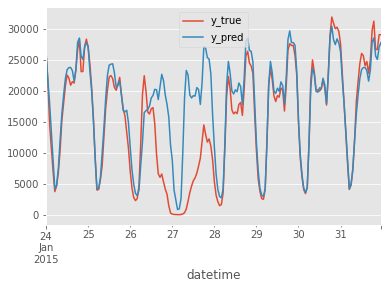

In [373]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot()

### Differences by Zip Code

In [374]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot()
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

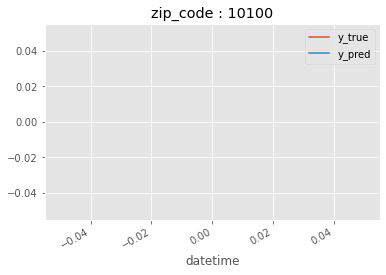

In [375]:
visualize_output_by_zipcode(test_df)

### Differences by Hour

<AxesSubplot:xlabel='hour'>

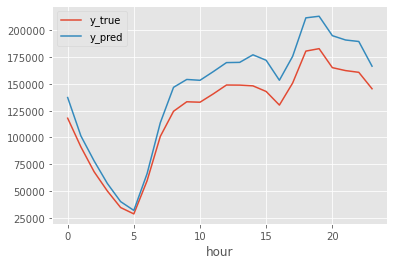

In [376]:
test_df[['hour', 'y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot()

- Pretty similar between 0-4am, but the difference gets larger between 7am-8pm

### Differences by Weekday

<AxesSubplot:xlabel='weekday'>

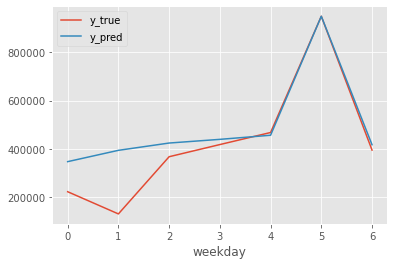

In [377]:
test_df[['weekday', 'y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot()

### Differences by Weekdays/Weekend

<AxesSubplot:xlabel='is_weekend'>

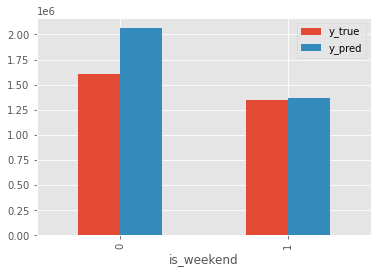

In [378]:
test_df[['is_weekend', 'y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar')

- The model couldn't accurately predict for weekdays, but it was able to predict quite well for weekend
- There was a large difference for Monday (0) and Tuesday (1), which could be the reason why the prediction for weekday was not good as the weekend

# Feature Engineering

In [395]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (
  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (
  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (
  # zip_code & datetime join
  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (
  # zip_code, datetime demand
  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (
  # zip_code, datetime 
  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
  LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=project_id)

INFO - pandas_gbq.gbq - Total time taken 34.34 s.
Finished at 2021-04-01 19:37:44.


CPU times: user 12 s, sys: 617 ms, total: 12.6 s
Wall time: 34.3 s


In [396]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt
278251,14801,2015-01-31 19:00:00,1,31,5,19,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278252,14801,2015-01-31 20:00:00,1,31,5,20,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278253,14801,2015-01-31 21:00:00,1,31,5,21,1,0,0.0,1.0,0.0,0.0,0.01,0.0,0.0,0.0
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


In [397]:
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [398]:
# Train/Test Split
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [399]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [400]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

# fill Nan
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')

In [401]:
x_train = train_df.copy()
x_test = test_df.copy()

In [402]:
len(x_train)

206448

In [403]:
len(x_test)

71808

### Modeling

In [404]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [405]:
@ex.capture
def get_model(n_estimators,n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)

In [406]:
@ex.main
def run(_log, _run):
    global rf_reg_1, rf_pred_1
    rf_reg_1 = get_model()
    rf_reg_1.fit(x_train, y_train_raw)
    rf_pred_1 = rf_reg.predict(x_test)
    # Save in Log file
    _log.info("Predict End")
    score = evaluation(y_test_raw, rf_pred_1)
    _run.log_scalar('model_name', rf_reg_1.__class__.__name__)
    
    # Metrics
    _run.log_scalar('metrics', score)
    
    # Result
    return score.to_dict()

In [407]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "5"
INFO - run - Predict End
INFO - nyc-demand-prediction - Result: {'mape': {'score': nan}, 'mae': {'score': 6.9120320855614965}, 'mse': {'score': 987.7480186051695}}
INFO - nyc-demand-prediction - Completed after 0:00:03


In [408]:
experiment_result.config

{'fit_intercept': True,
 'normalize': False,
 'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 10,
 'n_jobs': -1,
 'num_leaves': 31,
 'seed': 2448503}

In [409]:
parsing_output(5)

,mae,mape,mse
score,6.912032,NaN,987.748019


<AxesSubplot:>

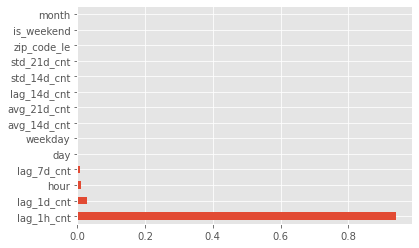

In [410]:
feature_importances = pd.Series(rf_reg_1.feature_importances_, index=x_train.columns)
feature_importances.nlargest(15).plot(kind='barh')

# Final Result Analysis

### XGBoost

In [362]:
parsing_output(2)

,mae,mape,mse
score,57.678736,538.520156,16512.330237


### LightGBM

In [363]:
parsing_output(3)

,mae,mape,mse
score,48.241491,421.685697,13755.68489


### RF

In [364]:
parsing_output(4)

,mae,mape,mse
score,35.250119,186.233078,12155.350074


### RF - After Feature Engineering

In [409]:
parsing_output(5)

,mae,mape,mse
score,6.912032,NaN,987.748019


### Restore Data
- Label Encoding, Deleted Data, Datetime -> reverse encoding again

In [411]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred_1
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [412]:
test_df = test_df.set_index('datetime')

### Differences by Datetime

<AxesSubplot:xlabel='datetime'>

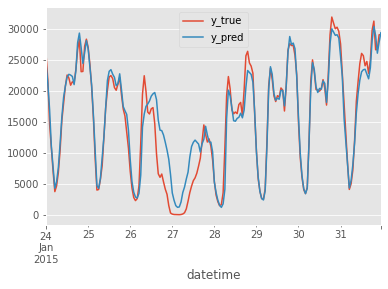

In [413]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot()

### Differences by Zip Code

In [414]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot()
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

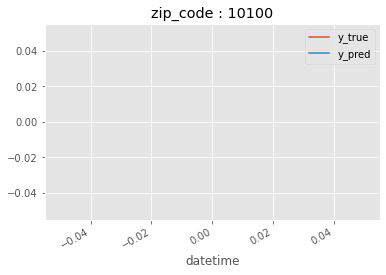

In [415]:
visualize_output_by_zipcode(test_df)

### Differences by Hour

<AxesSubplot:xlabel='hour'>

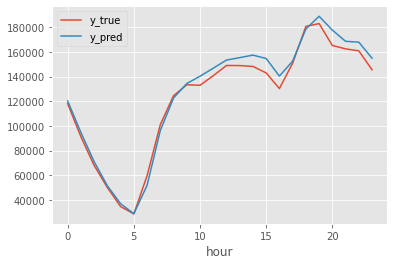

In [416]:
test_df[['hour', 'y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot()

- Overall it's quite similar, so the feature engineering helped the prediction accuracy 

### Differences by Weekday

<AxesSubplot:xlabel='weekday'>

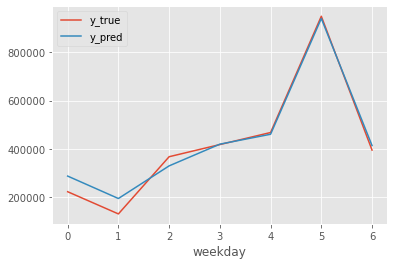

In [417]:
test_df[['weekday', 'y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot()

### Differences by Weekdays/Weekend

<AxesSubplot:xlabel='is_weekend'>

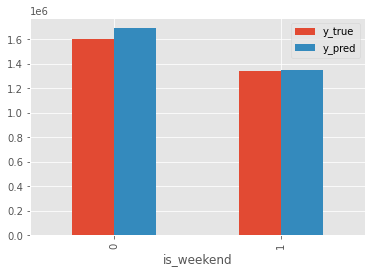

In [418]:
test_df[['is_weekend', 'y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar')

- After the feature engineering, the model was able to improve prediction for weekdays